# import

In [ ]:
import numpy as np
import pandas as pd
import os
from IPython.display import display, HTML
from ast import literal_eval
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.spatial import distance
from scipy.spatial import KDTree
import shutil
from PIL import Image

def load_in_behavioural_data(current_path):

    day2_tracking = False
    port_tracking2,movement_tracking2,port_tracking1,movement_tracking1 = None, None, None, None
    
    for day_folder in os.listdir(current_path):
        day_path = os.path.join(current_path, day_folder)
        if 'day2' in day_path:
            print(f'Processing {day_folder}')
            for file in os.listdir(day_path):
                if file.endswith('.csv'):
                    poke_df_2 = pd.read_csv(os.path.join(day_path,file))

                if file.endswith('.h5'):
                    print('day 2 tracking found')
                    day2_tracking = True
                    # tracking exists
                    if 'port' in file or 'PORT' in file:
                        port_tracking2 = get_dlc_data(os.path.join(day_path, file),interp = True,val = 0.9995)
                    else:
                        movement_tracking2 = get_dlc_data(os.path.join(day_path, file),interp = True,val = 0.9995)  
                        print('--------------')                      
    for day_folder in os.listdir(current_path):
        day_path = os.path.join(current_path, day_folder)
        if 'day1' in day_path:
            print(f'Processing {day_folder}')
            for file in os.listdir(day_path):
                if file.endswith('.csv'):
                    poke_df_1 = pd.read_csv(os.path.join(day_path,file))
                if day2_tracking:
                    # if day 2 tracking exists, then we also load in the day 1 tracking
                    if file.endswith('.h5'):
                        print('day 1 tracking found')
                        # tracking exists
                        if 'port' in file or 'PORT' in file:
                            port_tracking1 = get_dlc_data(os.path.join(day_path, file),interp = True,val = 0.9995)
                        else:
                            movement_tracking1 = get_dlc_data(os.path.join(day_path, file),interp = True,val = 0.9995)
                            print('--------------') 

    return poke_df_1, movement_tracking1, port_tracking1, poke_df_2, movement_tracking2, port_tracking2


def get_dlc_data(Tracking_data_path,interp,val):
    # Load in '.h5' file:
    h5_read=pd.read_hdf(Tracking_data_path)
    # Access the head center      
    scorer =  h5_read.columns.tolist()[0][0]

    colum_headings = h5_read[scorer].columns
    bodyparts = np.unique([item[0] for item in colum_headings])

    output = {}
    for name in bodyparts:
        dat_ =  h5_read[scorer][name]
        if interp:
            dat_interped=clean_and_interpolate(dat_,val)
        output[name] =[dat_interped]
    return output


def clean_and_interpolate(data,threshold):

    bad_confidence_inds = np.where(data.likelihood.values<threshold)[0]
    newx = data.x.values
    newx[bad_confidence_inds] = 0
    newy = data.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    data['interped_x'] = interped_x
    data['interped_y'] = interped_y
    
    return data

def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                   

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                 

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    return(coords_list)

def find_awake_ppseq_base_path(mir,awake_ppseq_path):
    awake_ppseq_mirs = np.array(['_'.join(item.split('_')[0:3]) for item in os.listdir(awake_ppseq_path)])
    awake_file_mir = None
    for ind,item in enumerate(awake_ppseq_mirs):
        if item in mir:
            awake_file_mir = os.listdir(awake_ppseq_path)[ind]
    if awake_file_mir == None:
        raise Exception("No awake file found for mir")
    else:
        return(os.path.join(awake_ppseq_path,awake_file_mir))
    
def process_awake_ppseq_path(m_i_r, expert_awake_ppseq_path, learning_awake_ppseq_path):
    try: 
        awake_ppseq_base_path = find_awake_ppseq_base_path(m_i_r,expert_awake_ppseq_path)
    except:
        awake_ppseq_base_path = find_awake_ppseq_base_path(m_i_r,learning_awake_ppseq_path)
    print(f'Awake PPSeq base path: {awake_ppseq_base_path}')
    return awake_ppseq_base_path

def get_sequence_regions(mir,awake_ppseq_base_path,sequence_order):
    standard_space_path = awake_ppseq_base_path + r'//analysis_output/reordered_recolored/fixed_standard_space//'
    overlap_positions_standard_space = np.load(standard_space_path + 'overlap_positions_standard_space.npy',allow_pickle=True)

    mir_row = None
    for ind, row in sequence_order.iterrows():
        if row.mir in mir:
            mir_row = row
    seq_order = literal_eval(mir_row.seq_order)
    continuous_regions = []
    fig, ax = plt.subplots(1,1,figsize=(8, 2))
    for i,seq in enumerate(seq_order):
        ax.plot(overlap_positions_standard_space[seq],np.ones(len(overlap_positions_standard_space[seq]))*i,'o')
        continuous_regions += [find_largest_continuous_region(overlap_positions_standard_space[seq])]

    # create new df 
    continuous_regions_df = pd.DataFrame(continuous_regions,columns=['start','end'])
    continuous_regions_df['sequence'] = seq_order
    return continuous_regions_df

def find_largest_continuous_region(positions, max_gap=5, circular_max=100):
    # Sort positions for easier processing
    positions = sorted(positions)
    
    # Identify continuous regions
    regions = []
    current_region = [positions[0]]
    
    for i in range(1, len(positions)):
        if positions[i] - positions[i - 1] < max_gap:
            current_region.append(positions[i])
        else:
            regions.append(current_region)
            current_region = [positions[i]]
    
    regions.append(current_region)  # Append the last region
    
    # Handle circular case (if the first and last regions can be merged)
    if regions and len(regions) > 1:
        first_region = regions[0]
        last_region = regions[-1]
        
        if (circular_max - last_region[-1] + first_region[0]) < max_gap:
            merged_region = last_region + first_region
            regions = regions[1:-1]  # Remove first and last
            regions.append(merged_region)
    
    # Find the largest region
    largest_region = max(regions, key=lambda r: r[-1] - r[0] if r[-1] >= r[0] else (r[-1] + circular_max - r[0]))
    
    # Determine start and end points
    start = largest_region[0]
    end = largest_region[-1]
    
    return start, end

# loop over and load in behavioural data from useable mirs
def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path

def make_transition_df(df):
    transitions = []
    in_in_Latency = []
    for index in range(len(df.Port.values)):
        if index < len(df.Port.values)-1:
            transit = int(str(df.Port.values[index]) + str(df.Port.values[index+1]))
            transitions += [transit]
            in_in_diff = df.PokeIn_Time.values[index+1] - df.PokeIn_Time.values[index]
            in_in_Latency += [in_in_diff]
        
 
    transit_df = pd.DataFrame({'Trial_id': df.Trial_id.values[0:-1], 
                                'Transition_type': transitions,
                                'in_in_Latency': in_in_Latency,
                                '2s_Time_Filter_in_in': list((np.array(in_in_Latency) <= 2).astype(int))})
    return transit_df

def find_error_rates(transition_sync_df): 

    Correct = [21,16,63,37,72]
    Error = [23,24,25,26,27,28,12,13,14,15,17,18,61,62,64,65,67,68,31,32,34,35,36,38]
    Neutral = [11,22,33,66,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,71,73,74,75,76,77,78,81,82,83,84,85,86,87,88]

    filt_df = transition_sync_df[transition_sync_df.in_in_Latency < 2]

    corrects = 0
    errors = 0
    neutral = 0
    for transit in filt_df.Transition_type.values:
        if transit in Correct:
            corrects += 1
        elif transit in Error:
            errors += 1
        elif transit in Neutral:
            neutral += 1
        else:
            raise Exception("Transition type not found!")
    total = corrects + errors + neutral
    return corrects/total,errors/total,neutral/total

def get_perfect_sequence_score(transition_sync_df):
    transitions = []
    Tfilt = []
    latency = []
    for trial in transition_sync_df.groupby('Trial_id'):
        trial_id = trial[0]
        trial_df = trial[1]
        transitions += [trial_df.Transition_type.values]
        latency += [trial_df.in_in_Latency.values] 
        # time filter
        Tfilt += [trial_df['2s_Time_Filter_in_in'].values]

    # for each trial,remove transntions and latencies that were too long and split into reaminign time relevant fragments - but for both latency types, hence the loop
    timesplitseqs = [] 
    timesplitlatencies = []
    for trial_index,time_filter in enumerate(Tfilt):
        start_end_inds = list(np.where(np.array(time_filter)[:-1] != np.array(time_filter)[1:])[0])
        split = parts(transitions[trial_index],list(np.array(start_end_inds)+1))
        split2 = parts(time_filter,list(np.array(start_end_inds)+1))
        TfiltSplit = RemoveSlowSequences(split,split2)
        timesplitseqs += [TfiltSplit]
        # now do the same for the latency data
        split3 = parts(latency[trial_index],list(np.array(start_end_inds)+1))
        TfiltSplit_latencies = RemoveSlowSequences(split3,split2)
        timesplitlatencies += [TfiltSplit_latencies]

        
    # for fragments in each trial,sort and trim so that seqs start at initiation port poke and then remove fragments that are too short. ie. remove any transitions sequences that dont inlcude the first port or are just a single transition.
    processed_seqs,processed_latencies = aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies)  ## use  timesplitlatencies[0] for Out to in Transition times 

    ## determine perfect sequences and correspondng training level and shaping parameters
    trial_perfects = []
    for trial_index,fragments in enumerate(processed_seqs):
        perfect = []
        for fragment in fragments:
            if sequence_contains_sequence(fragment,[21, 16, 63, 37]):
                perfect += [1]
            else:
                perfect += [0]
        trial_perfects = trial_perfects + [perfect]  
        
    ## code if i jst want average from all fragments
    # pefs = 0
    # total = 0
    # for item in trial_perfects:
    #     pefs += sum(item)
    #     total += len(item)  

    # code if i want to average over each trial
    trial_by_trial_p_score = []
    for trial_ in trial_perfects:
        if len(trial_) > 0:
            trial_by_trial_p_score += [sum(trial_)/len(trial_)]
            
    return np.mean(trial_by_trial_p_score)

def reward_rate(behav_sync_df):
    # transitions per reward
    behav_sync_df.Reward_Times.values
    indices = np.where(~np.isnan(behav_sync_df.Reward_Times.values))[0]
    transits_per_reward = indices[-1]/(len(indices)-1) #-1 to turn it into the number of transitions 
    # seconds per reward 
    mask = ~np.isnan(behav_sync_df.Reward_Times.values)
    start_offset = behav_sync_df.Trial_Start[0]
    last_reward_time = behav_sync_df[mask].Reward_Times.values[-1] - start_offset
    seconds_per_reward = last_reward_time / len(indices)
    return transits_per_reward,seconds_per_reward

def sequence_contains_sequence(haystack_seq, needle_seq):
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            return True
    return False
            
def parts(list_, indices):
    indices = [0]+indices+[len(list_)]
    return [list_[v:indices[k+1]] for k, v in enumerate(indices[:-1])]

def RemoveSlowSequences(split,split2):
    timefiltered_split = []
    for i,item in enumerate(split2):
        if item[0] == 1:
            timefiltered_split = timefiltered_split + [split[i]]
    return timefiltered_split

def aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies):
    
    newseqs = []
    newlatencies = []
    # align to first poke:
    for index_1,fragments in enumerate(timesplitseqs):
        current_newseqs = []
        current_newlatencies = []
        count = -1
        seqs = False
        for index_2,sequence in enumerate(fragments):
            for index_3,transit in enumerate(sequence):
                if not str(transit)[0] == str(transit)[1]: # remove repeat pokes
                    if str(transit)[0] == '2':
                        seqs = True
                        current_newseqs = current_newseqs + [[]]
                        current_newlatencies = current_newlatencies + [[]]
                        count = count + 1
                        current_newseqs[count] = current_newseqs[count] + [transit]
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
                    elif seqs == True:
                        current_newseqs[count] = current_newseqs[count] + [transit]   
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
            seqs = False
 
        newseqs = newseqs + [current_newseqs]
        newlatencies = newlatencies + [current_newlatencies]
    return(newseqs,newlatencies)

def find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer,radius):

    ## add to the start and end of each to ensure that the segmetns overlap - this is impotant for joining them into a representaitve continuous line 
    T1_start_ind = np.array(T1_start_ind) - buffer
    T2_start_ind = np.array(T2_start_ind) - buffer
    T3_start_ind = np.array(T3_start_ind) - buffer
    T4_start_ind = np.array(T4_start_ind) - buffer
    T1_end_ind = np.array(T1_end_ind) + buffer
    T2_end_ind = np.array(T2_end_ind) + buffer
    T3_end_ind = np.array(T3_end_ind) + buffer
    T4_end_ind = np.array(T4_end_ind) + buffer


    # plot these filtered trajectories:
    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(6, 4))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)

    segment1 = plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,'red',current_x,current_y)
    segment2 = plot_and_create_xy_segments(T2_start_ind,T2_end_ind,ax,'green',current_x,current_y)
    segment3 = plot_and_create_xy_segments(T3_start_ind,T3_end_ind,ax,'blue',current_x,current_y)
    segment4 = plot_and_create_xy_segments(T4_start_ind,T4_end_ind,ax,'grey',current_x,current_y)

    a_curve1 = interpolate_to_longest_and_find_average_curve(segment1,'None')
    a_curve2 = interpolate_to_longest_and_find_average_curve(segment2,'None')
    a_curve3 = interpolate_to_longest_and_find_average_curve(segment3,'None')
    a_curve4 = interpolate_to_longest_and_find_average_curve(segment4,'None')

    x = [point[0] for point in a_curve1]
    y = [point[1] for point in a_curve1]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve2]
    y = [point[1] for point in a_curve2]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve3]
    y = [point[1] for point in a_curve3]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve4]
    y = [point[1] for point in a_curve4]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    ax.invert_yaxis()
    
    return a_curve1,a_curve2,a_curve3,a_curve4

def plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,col,current_x,current_y):
    segment1 = []
    for i in range(len(T1_start_ind)):
        ax.plot(current_x[T1_start_ind[i]:T1_end_ind[i]],current_y[T1_start_ind[i]:T1_end_ind[i]],'-', color = col, alpha = 1)    
        x_vals = current_x[T1_start_ind[i]:T1_end_ind[i]]
        y_vals = current_y[T1_start_ind[i]:T1_end_ind[i]]
        xy_coords = []
        for index,x in enumerate(x_vals):
            xy_coords += [(x,y_vals[index])]
        segment1 += [xy_coords]
    return(segment1)

def extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,exclude_port_1,exclude_port_2,exclude_port_3):

    start_ind = []
    end_ind = []


    index = 0
    while index < len(threshold_breaks[:-1]):
        break_ = threshold_breaks[index]
        if break_ == start_port and not threshold_breaks[index+1] ==start_port:
            # find min valin this that is larger than current - ie. next index
            p3_ind = find_next_val(index,threshold_breaks,frame_filter,end_port)
            # ignore any really bad ones that enter othe rports first, the -1 takes care of the excluded trajectories (gets rid of weird noise hwere the DLC tracking jumps outsid eof the task zone)
            if not exclude_port_1 in threshold_breaks[index:p3_ind] and not exclude_port_2 in threshold_breaks[index:p3_ind] and not exclude_port_3 in threshold_breaks[index:p3_ind] and not -1 in threshold_breaks[index:p3_ind]:
                if p3_ind != -1:
                    start_ind += [index-3]
                    end_ind += [p3_ind+3]
                    if not index == (p3_ind - 1):
                        index = p3_ind - 1
                    else:
                        index = p3_ind
                else:
                    index+=1
            else:
                index += 1
        else:
            index +=1

    return start_ind, end_ind
def find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius):
    # find task relevant tracking periods
    #extract times mouse is close to each behavioural port


    current_x = back_head_centre_df.interped_x.values
    current_y = back_head_centre_df.interped_y.values

    port_positions = []
    for i in range(5):
        port = [p1,p2,p3,p4,p5][i]
        port_positions += [[np.median(port.interped_x),np.median(port.interped_y)]]
        
    port_centroids = port_positions
        
    coords = []
    for ind_,item in enumerate(current_x):
        coords += [[item,current_y[ind_]]]

    
    threshold_breaks = np.zeros(len(coords))
    # for each port we care about find where the mouse breaks the distcance threshold
    for ind_ in range(0,len(port_centroids)):
        threshold = radius
        target = port_centroids[ind_]
        closest,indicies = closest_points(target, coords, threshold)
        
        threshold_breaks[indicies] = ind_ + 1

    # exclude (by labelling with -1) any times the trajetcory goes outside of the port area
    half_dist = (port_centroids[0][-1] - port_centroids[4][-1])/2
    exclusion_mask = (np.array(current_y) < (port_centroids[0][-1] + half_dist)) * (np.array(current_y) > (port_centroids[4][-1] - half_dist))
    exclusion_inds = np.where(exclusion_mask == False)
    threshold_breaks[exclusion_inds] = -1
    
    return threshold_breaks,port_centroids,current_x,current_y, radius


def find_closest_points(curve1, curve2, cut):
    """Find the closest points between two curves."""
    if cut:#only use the very end of the line to do the joining procedure to prevent verlap errors
        curve1 = np.array(curve1[-100::])
        curve2 = np.array(curve2[0:100])
    else:     
        curve1 = np.array(curve1)
        curve2 = np.array(curve2)
    
    dist_matrix = distance.cdist(curve1, curve2)
    min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    return curve1[min_idx[0]], curve2[min_idx[1]]

def join_curves(curve1, curve2, cut = True):
    """Join two curves at the closest points if they touch, otherwise join endpoints."""
    point1, point2 = find_closest_points(curve1, curve2, cut)
    
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:  # Assuming touching if distance < small epsilon
        # Directly connect at closest point
        print('overlap detected')
        index1 = curve1.index(point1.tolist())
        index2 = curve2.index(point2.tolist())
        return curve1[:index1+1] + curve2[index2:]
    else:
        # Join by endpoints
        return curve1 + curve2
    
def join_make_full_circle(curve1, cut = False):
    """Join two curves at the closest points if they touch, otherwise join endpoints."""
    point1, point2 = find_closest_points(curve1[0:100], curve1[-100::], cut)
    
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:  # Assuming touching if distance < small epsilon
        # Directly connect at closest point
        print('overlap detected!')
        index1 = curve1[0:100].index(point1.tolist())
        index2 = curve1[-100::].index(point2.tolist())
        index2 = index2 + (len(curve1) - 100)
        return curve1[index1:index2]
    else:
        # Join by endpoints
        return curve1 + [curve1[0]]

def resample_curve(complete_average, num_points):
    """
    Resample the given curve so that it has `num_points` evenly spaced points.
    """
    a_curve_copy = np.array(complete_average.copy())
    data_points = len(a_curve_copy)
    
    # Compute cumulative distance along the curve
    distances = [0]
    for i in range(1, data_points):
        distances.append(distances[-1] + math.dist(a_curve_copy[i], a_curve_copy[i-1]))
    total_length = distances[-1]
    
    # Create new evenly spaced distance values
    new_distances = np.linspace(0, total_length, num_points)
    
    # Interpolate new points
    x_vals = [p[0] for p in a_curve_copy]
    y_vals = [p[1] for p in a_curve_copy]
    x_interp = np.interp(new_distances, distances, x_vals)
    y_interp = np.interp(new_distances, distances, y_vals)
    
    return np.column_stack((x_interp, y_interp))

def plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids):
    fig, axs = plt.subplots(1, 2,figsize=(8, 2))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius_used, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)
        if ind == 0:
            x = [point[0] for point in complete_average]
            y = [point[1] for point in complete_average]
            ax.plot(x, y, '--', color ='black',alpha = 1)
        if ind == 1:
            x = [point[0] for point in standard_av_curve]
            y = [point[1] for point in standard_av_curve]
            ax.plot(x, y, 'x', color ='black',alpha = 1)

        ax.invert_yaxis()


def shift_curve_start(resampled_curve, p5, radius=45):
    """
    Shift the curve start to the first point that exits a circle of given radius from p5.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param p5: Tuple (x, y) representing the circle centroid
    :param radius: Radius of the circle
    :return: Shifted curve starting from the first point outside the circle
    """
    # Find the first index where the point is outside the circle
    for i, point in enumerate(resampled_curve):
        if math.dist(point, p5) > radius:
            break  # Found the new start index
    
    # Rearrange the curve so this new point becomes the start
    shifted_curve = np.vstack((resampled_curve[i:], resampled_curve[:i]))  # Maintain order
    
    return shifted_curve

def closest_points(target, points, threshold):
    import math
    closest = []
    indicies = []
    for index,point in enumerate(points):
        distance = math.dist(target,point)
        if distance <= threshold:
            closest.append(point)
            indicies.append(index)
    return closest,indicies

def find_next_val(index,threshold_breaks,frame_filter,port_type):
    p2_indicies = np.where(threshold_breaks == port_type)[0]
    try:
        p2_min_val = min(i for i in p2_indicies if i > index)
        distance = p2_min_val - index
    except:
        distance = 9999999
    if distance<frame_filter:
        return p2_min_val
    else:
        return -1
    
def find_similar_segments(tracking, template, threshold, centroid_thresh=3, radius=3):
    """
    Find similar segments with centroid pre-filtering.
    
    Parameters:
        tracking: Nx2 array of (x,y) points.
        template: Mx2 array of template (x,y) points.
        threshold: DTW distance threshold.
        centroid_thresh: Pre-filter threshold on centroid distance.
        radius: DTW radius for fastdtw.
    
    Returns:
        List of matching segment indices.
    """
    tracking = np.array(tracking)
    template = np.array(template)
    M = len(template)
    matches = []

    for start in tqdm(range(len(tracking) - M + 1), desc="Processing segments"):
        window = tracking[start : start + M]

        # Pre-filter: Check centroid distance first
        if centroid_distance(window, template) > centroid_thresh:
            continue  # Skip if centroids are too far apart

        # Run DTW only if centroid distance is low
        distance, _ = fastdtw(window, template, radius=radius, dist=euclidean)
        if distance < threshold:
            matches.append((start, start + M))

    return matches

def centroid_distance(window, template):
    """
    Compute Euclidean distance between centroids of the window and the template.
    """
    centroid_window = np.mean(window, axis=0)
    centroid_template = np.mean(template, axis=0)
    return euclidean(centroid_window, centroid_template)

def find_motif_points(continuous_regions_df, standard_av_curve, port_centroids, seq_colours, radius_used,num_intermediate_points=5):

    start_end_intermediate = []
    fig, axs = plt.subplots(1, len(continuous_regions_df), figsize=(4 * len(continuous_regions_df), 2))

    for i, row in continuous_regions_df.iterrows():
        buffer_ = 2  # 2% buffer on each side
        start = row.start - buffer_
        end = row.end + buffer_
        
        # Handle circular nature at 100%
        if start < 0:
            start += 100
        if end > 100:
            end -= 100
        
        # Compute percentage points
        if start < end:
            positions = np.linspace(start, end, num_intermediate_points + 2)[1:-1]  # Exclude start and end
        else:  # Wraps around 100%
            positions = np.linspace(0, (100-start)+end, num_intermediate_points + 2)[1:-1]  # Exclude start and end
            positions = start + positions
            positions = [position-100 if position>100 else position for position in positions]
        
        
        intermediate_xy = get_percentage_points(standard_av_curve, positions)
        s_, e_ = get_percentage_points(standard_av_curve, [start, end])
        
        # Plot
        plot_percentage_interval(standard_av_curve, [start, end], port_centroids, axs[i], row.sequence, seq_colours[int(row.sequence) + 1],radius_used)
        
        # Store results
        start_end_intermediate.append([s_, *intermediate_xy, e_])

    # Create column names dynamically based on number of intermediate points
    columns = ["start_xy"] + [f"intermediate_{i}_xy" for i in range(1, num_intermediate_points + 1)] + ["end_xy"]
    return pd.DataFrame(start_end_intermediate, columns=columns)

def get_percentage_points(resampled_curve, percentages):
    """
    Get the points at specific percentage locations along the resampled curve.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List of percentages (0-100) where points should be extracted
    :return: List of (x, y) points corresponding to the given percentages
    """
    num_points = len(resampled_curve)
    indices = [int(p / 100 * (num_points - 1)) for p in percentages]  # Convert percentage to index
    return resampled_curve[indices]

def plot_percentage_interval(resampled_curve, percentages,port_centroids,ax,sequence_name,colour_,radius_used):
    """
    Plot the full resampled curve and highlight the region between two percentage points.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List [start%, end%] defining the highlighted region
    """
    num_points = len(resampled_curve)
    start_idx = int(percentages[0] / 100 * (num_points - 1))
    end_idx = int(percentages[1] / 100 * (num_points - 1))

    # Handle case where interval wraps around (e.g., 97% to 14%)
    if start_idx <= end_idx:
        highlight_indices = range(start_idx, end_idx + 1)
    else:
        highlight_indices = list(range(start_idx, num_points)) + list(range(0, end_idx + 1))

    # Extract x, y coordinates
    x_vals, y_vals = resampled_curve[:, 0], resampled_curve[:, 1]

    # Plot full curve
    ax.plot(x_vals, y_vals, color='black', linewidth=1, label="Full Curve")

    # Highlight section
    highlighted_x = x_vals[list(highlight_indices)]
    highlighted_y = y_vals[list(highlight_indices)]
    ax.plot(highlighted_x, highlighted_y, color=colour_, linewidth=2, label="Highlighted Region")

    # Scatter start and end points
    ax.scatter([x_vals[start_idx], x_vals[end_idx]], 
                [y_vals[start_idx], y_vals[end_idx]], 
                color='blue', zorder=3, label="Start/End Points")

    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, radius_used, color='grey', alpha = 0.2)
        ax.add_patch(circle1)
        
    ax.set_title(f"sequence {int(sequence_name)+1}")
        
    ax.invert_yaxis()
    
def process_and_validate_trajectories(tracking, matches, template,add_amount,frame_filter,dist_filter,num_points):
    """
    Process each trajectory by extending, trimming, and validating.

    Parameters:
        tracking: Nx2 array of (x, y) points.
        matches: List of (start, end) indices of matching segments.
        template: Mx2 array of template (x, y) points.
        frame_filter: Maximum allowed length for a trajectory.

    Returns:
        List of processed (start, end) indices for valid trajectories.
    """
    processed_trajectories = []

    # Define the start and end points from the template
    start_centroid = template[0]
    end_centroid = template[-1]

    for start, end in matches:
        # Step 1: Extend the trajectory
        start = start - add_amount
        end = end + add_amount
        extended_trajectory = tracking[start:end]
        # Step 2: Find closest points to the start and end centroids in teh first and l;ast 30% of the trajectory
        closest_start_indices,start_distances = find_closest_to_centroid(extended_trajectory[0:int(abs(len(extended_trajectory)*0.3))], start_centroid, num_points)
        closest_end_indices,end_distances = find_closest_to_centroid(extended_trajectory[int(abs(len(extended_trajectory)*0.6))::], end_centroid, num_points)
        
        # if closest is too far away then skip
        if start_distances[np.min(closest_start_indices)] > dist_filter:
            continue
        if end_distances[np.max(closest_end_indices)] > dist_filter:
            continue
        
        # Step 3: Trim the trajectory
        trimmed_start = start + np.min(closest_start_indices)
        trimmed_end =start + int(abs(len(extended_trajectory)*0.6)) + np.max(closest_end_indices)
    
        
        # Step 4: Validate length
        if (trimmed_end-trimmed_start) > frame_filter:
            continue  # Skip trajectories longer than frame_filter
        
        # step 5, Add valid trajectory indices to the final list
        processed_trajectories.append([trimmed_start,trimmed_end])

    return processed_trajectories

def find_closest_to_centroid(tracking_, centroid, num_points=100):
    """
    Find the indices of the `num_points` closest points to a given centroid.

    Parameters:
        tracking: Nx2 array of (x, y) points.
        centroid: 1x2 array of the centroid coordinates.
        num_points: Number of closest points to find.

    Returns:
        Indices of the closest points in the tracking array.
    """
    distances = distance.cdist(tracking_, [centroid], metric='euclidean').flatten()
    closest_indices = np.argsort(distances)[:num_points]
    return closest_indices,distances

def remove_overlaps(start_end_inds):
    # Sort by start index to make overlap checking easier
    start_end_inds.sort()

    to_remove = []

    for i in range(len(start_end_inds)):
        for j in range(i + 1, len(start_end_inds)):
            start1, end1 = start_end_inds[i]
            start2, end2 = start_end_inds[j]

            # Check if there's an overlap of more than 5 indices
            if start2 <= end1 and end2 >= start1:  # They overlap
                overlap = min(end1, end2) - max(start1, start2) + 1
                if overlap > 5:
                    # Remove the longer one
                    if end1 - start1 > end2 - start2:
                        to_remove.append(j)
                    else:
                        to_remove.append(i)

    # Remove duplicates from the to_remove list and create the new list
    to_remove = sorted(set(to_remove), reverse=True)
    for index in to_remove:
        start_end_inds.pop(index)

    return start_end_inds

def interpolate_to_longest_and_find_average_curve(curves,num_points):
    
    if num_points == 'None':
        # Find the length of the longest curve
        max_length = max([len(curve) for curve in curves])
    else:
        max_length = num_points

    # Interpolate each curve to the length of the longest curve
    interpolated_curves = []
    for curve in curves:
        if len(curve) > 0:
            x = [point[0] for point in curve]
            y = [point[1] for point in curve]

            # find lots of points on the piecewise linear curve defined by x and y
            M = max_length
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)

            interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])

    # # Average the x and y coordinates of all the interpolated curves
    average_curve = []
    for i in range(max_length):
        x_sum = 0
        y_sum = 0
        for curve in interpolated_curves:
            x_sum += curve[i][0]
            y_sum += curve[i][1]
        average_curve.append([x_sum / len(interpolated_curves), y_sum / len(interpolated_curves)])

    return average_curve

def closest_points_distances(line1, line2):
    tree = KDTree(line2)
    dist, index = tree.query(line1)
    return dist

def normalized_dtw(traj1, traj2):
    dtw_dist = dtw_distance(traj1, traj2)  # Original DTW distance
    norm_dtw = dtw_dist / (len(traj1) + len(traj2))  # Normalize by total length
    return norm_dtw

def dtw_distance(traj1, traj2):
    """
    Calculate the Dynamic Time Warping (DTW) distance between two trajectories.
    
    traj1, traj2: Lists of points [(x1, y1), (x2, y2), ...]
    Returns: The DTW distance as a float.
    """
    n, m = len(traj1), len(traj2)
    # Create a DP table initialized with infinity
    dp = np.full((n + 1, m + 1), np.inf)
    
    # Base case: matching the first point of each trajectory
    dp[0, 0] = 0

    # Fill the DP table
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = euclidean_distance(traj1[i - 1], traj2[j - 1])
            dp[i, j] = cost + min(dp[i - 1, j], dp[i, j - 1], dp[i - 1, j - 1])

    # The DTW distance is the value in the bottom-right corner of the DP table
    return dp[n, m]


def calculate_speed(trajectory, _1mm, fps):
    """
    Calculate the speed for a single trajectory.
    
    Parameters:
    - trajectory: List of tuples or arrays containing x, y coordinates [(x1, y1), (x2, y2), ...]
    - _1mm: Distance represented by 1mm in the coordinates
    - fps: Frames per second (tracking rate)
    
    Returns:
    - speed: The average speed for the trajectory (distance/time)
    """
    total_distance = 0
    total_time = 0
    
    # Calculate the total distance and total time
    for i in range(1, len(trajectory)):
        x1, y1 = trajectory[i - 1]
        x2, y2 = trajectory[i]
        
        # Euclidean distance between two consecutive points
        distance_mm = (np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) / _1mm
        time = 1 / fps  # Time between frames (1/fps)
        
        total_distance += distance_mm
        total_time += time
    
    # Average speed: total distance / total time
    speed = total_distance / total_time if total_time != 0 else 0
    return speed

def calculate_speed_variability(trajectories, _1mm, fps):
    """
    Calculate the speed variability (standard deviation) between different trajectories.
    
    Parameters:
    - trajectories: List of trajectories, where each trajectory is a list of (x, y) coordinates
    - _1mm: Distance represented by 1mm in the coordinates
    - fps: Frames per second (tracking rate)
    
    Returns:
    - speed_std: Standard deviation of speeds across all trajectories
    """
    speeds = []
    
    # Calculate speed for each trajectory
    for trajectory in trajectories:
        speed = calculate_speed(trajectory, _1mm, fps)
        speeds.append(speed)
    
    # Calculate the standard deviation of speeds
    speed_std = np.std(speeds)
    speed_mean = np.mean(speeds)
    
    return speed_std,speed_mean

def euclidean_distance(p1, p2):
    """Calculate the Euclidean distance between two points p1 and p2."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Create a function to save all open figures in one large PNG
def save_all_figs(filename="all_plots.png", dpi=100):
    figs = [plt.figure(num) for num in plt.get_fignums()]
    if not figs:
        print("No figures to save.")
        return

    # make the folder temp_figs
    if not os.path.exists('temp_figs'):
        os.makedirs('temp_figs')

    # Save each figure to a temporary image
    images = []
    for fig in figs:
        # Save each figure to a temporary buffer
        buf = f"temp_figs/temp_fig_{fig.number}.png"
        fig.savefig(buf, dpi=dpi)
        images.append(Image.open(buf))

    # Concatenate all images vertically
    total_width = max(im.width for im in images)
    total_height = sum(im.height for im in images)

    # Create a blank canvas for the concatenated image
    combined_image = Image.new("RGB", (total_width, total_height))

    # Paste each figure into the canvas
    y_offset = 0
    for im in images:
        combined_image.paste(im, (0, y_offset))
        y_offset += im.height

    # Save the concatenated image
    combined_image.save(filename)
    
    # delete the temp figs dir
    shutil.rmtree('temp_figs')
    
    
    print(f"All figures saved as {filename}.")

# main

In [232]:
# load in behavioural data from first and second day and extract relevant information


In [233]:
behaviour_path = r'Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\'
expert_awake_ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"
learning_awake_ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\awake\\"

Processing day2_12-11-2021
day 2 tracking found
day 2 tracking found
--------------
Processing day1_11-11-2021
day 1 tracking found
day 1 tracking found
--------------
Awake PPSeq base path: Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\136_1_3_run_2701023_1835
overlap detected
overlap detected
overlap detected
overlap detected!


Processing segments: 100%|██████████| 295568/295568 [04:54<00:00, 1004.56it/s] 


526


Processing segments: 100%|██████████| 295568/295568 [02:43<00:00, 1802.51it/s] 


242


Processing segments: 100%|██████████| 295568/295568 [02:41<00:00, 1829.83it/s] 


203


Processing segments: 100%|██████████| 295568/295568 [05:50<00:00, 842.86it/s]  


635


100%|██████████| 4/4 [00:47<00:00, 11.79s/it]


NameError: name 'Image' is not defined

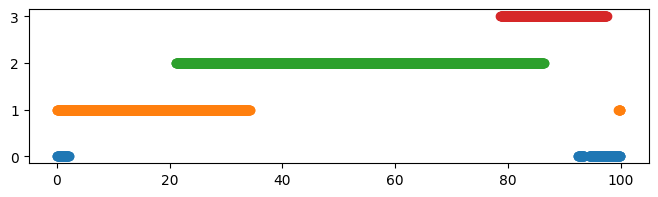

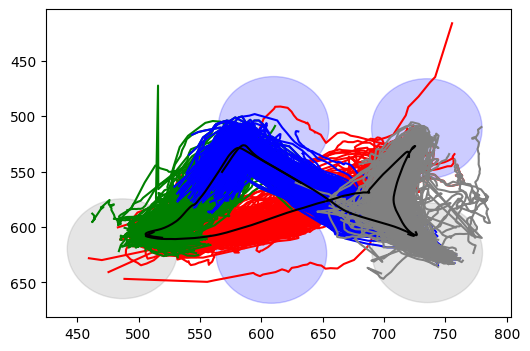

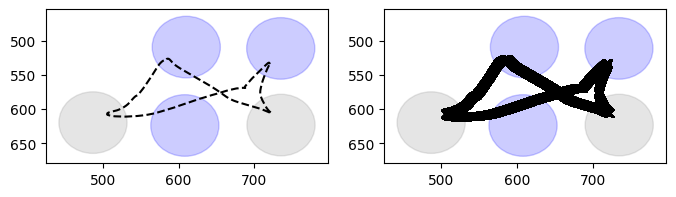

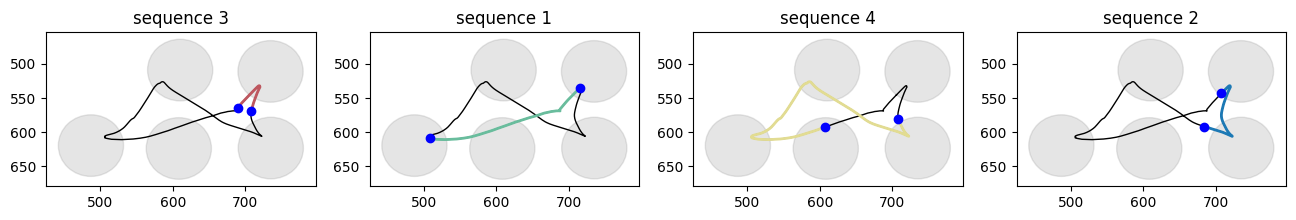

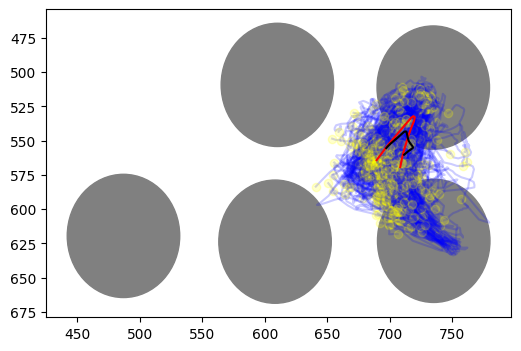

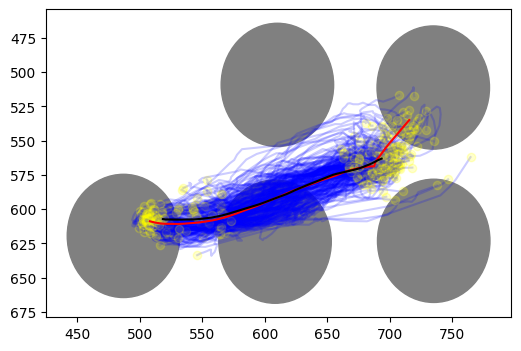

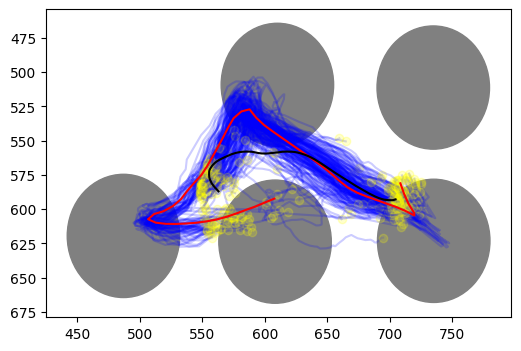

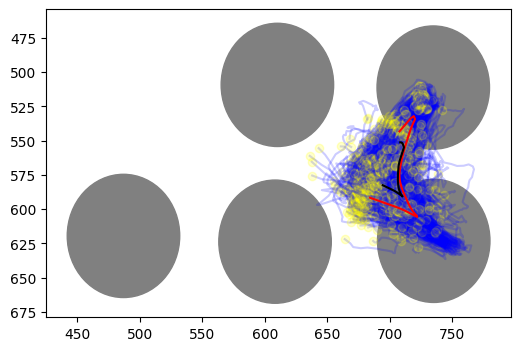

In [234]:
# loop over all animals 
for m_i_r in os.listdir(behaviour_path):
    
    # for now ignore the new data
    if not 'EJT' in m_i_r:
        continue
    
    current_path = os.path.join(behaviour_path, m_i_r)
    # load in the behavioural data
    display(HTML(f"<b>Processing behavioural data for: {m_i_r}</b>"))
    poke_df_1, movement_tracking1, port_tracking1, poke_df_2, movement_tracking2, port_tracking2 = load_in_behavioural_data(current_path)
    
    # make output paths
    for day_folder in os.listdir(current_path):
        day_path = os.path.join(current_path, day_folder)
        if 'day2' in day_path:
            out_path_2 = day_path + '\\processed\\'
            if not os.path.isdir(out_path_2):
                os.makedirs(out_path_2)
        if 'day1' in day_path:
            out_path_1 = day_path + '\\processed\\'
            if not os.path.isdir(out_path_1):
                os.makedirs(out_path_1)

    if 'AP5' in m_i_r:
        mir = m_i_r.replace('AP','ap')
    elif 'SEQ' in m_i_r: 
        mir = m_i_r.lower()
    else:  
        mir = m_i_r

    # get awake ppseq path:
    awake_ppseq_base_path = process_awake_ppseq_path(mir, expert_awake_ppseq_path, learning_awake_ppseq_path)

    # load sequence order
    try: 
        sequence_order = pd.read_csv(expert_awake_ppseq_path + r'sequence_order.csv')
    except:
        sequence_order = pd.read_csv(learning_awake_ppseq_path + r'sequence_order.csv')
    # get continuous regions information
    continuous_regions_df = get_sequence_regions(mir,awake_ppseq_base_path,sequence_order)


    # tracking data 
    p1_1,p2_1,p3_1,p4_1,p5_1 = port_tracking1['port2'][0],port_tracking1['port1'][0],port_tracking1['port6'][0],port_tracking1['port3'][0],port_tracking1['port7'][0]
    p1_2,p2_2,p3_2,p4_2,p5_2 = port_tracking2['port2'][0],port_tracking2['port1'][0],port_tracking2['port6'][0],port_tracking2['port3'][0],port_tracking2['port7'][0]

    back_head_centre_df_1 = movement_tracking1['head_centre'][0]
    back_head_centre_df_2 = movement_tracking2['head_centre'][0]


    ## extract simple metrics (number of trials, error rate, number of transitions,reward rate (vs time and vs transitions), number of each transition type)
    # number of trials
    num_trials_1 = len(poke_df_1.Trial_id.unique())
    num_trials_2 = len(poke_df_2.Trial_id.unique())
    # # error rate
    transit_df_1 = make_transition_df(poke_df_1)
    correct_transit_rate_1, error_transit_rate_1, neutral_transit_rate_1 = find_error_rates(transit_df_1)
    transit_df_2 = make_transition_df(poke_df_2)
    correct_transit_rate_2, error_transit_rate_2, neutral_transit_rate_2 = find_error_rates(transit_df_2)
    # perfect sequence score (behavioural score)
    perf_score_1 = get_perfect_sequence_score(transit_df_1)
    perf_score_2 = get_perfect_sequence_score(transit_df_2)
    # number of transitions
    total_transitions_1 = len(transit_df_1.Transition_type.values)
    total_transitions_2 = len(transit_df_2.Transition_type.values)
    # reward rate (vs time and vs transitions)
    transits_per_reward_1,seconds_per_reward_1 = reward_rate(poke_df_1)
    transits_per_reward_2,seconds_per_reward_2 = reward_rate(poke_df_2)

    ### make a df for the behavioural data i have collected:
    # Create the DataFrame with the existing variables
    pokedata_output_df_1 = pd.DataFrame({
        "num_trials": [num_trials_1],
        "correct_transit_rate": [correct_transit_rate_1],
        "error_transit_rate": [error_transit_rate_1],
        "neutral_transit_rate": [neutral_transit_rate_1],
        "perf_score": [perf_score_1],
        "total_transitions": [total_transitions_1],
        "transits_per_reward": [transits_per_reward_1],
        "seconds_per_reward": [seconds_per_reward_1]
    })  
    pokedata_output_df_2 = pd.DataFrame({
        "num_trials": [num_trials_2],
        "correct_transit_rate": [correct_transit_rate_2],
        "error_transit_rate": [error_transit_rate_2],
        "neutral_transit_rate": [neutral_transit_rate_2],
        "perf_score": [perf_score_2],
        "total_transitions": [total_transitions_2],
        "transits_per_reward": [transits_per_reward_2],
        "seconds_per_reward": [seconds_per_reward_2]
    })  

    #save out this data 
    pokedata_output_df_1.to_csv(out_path_1 + r'processed_poke_data_1.csv',index=False)
    pokedata_output_df_2.to_csv(out_path_2 + r'processed_poke_data_2.csv',index=False)


    # load in awake ppseq data for the same mir and pull in linearised thingy  
    for i_day in range(2): 
        if i_day == 0:
            back_head_centre_df = back_head_centre_df_1
            p1,p2,p3,p4,p5 = p1_1,p2_1,p3_1,p4_1,p5_1
            out_p = out_path_1
        else:
            back_head_centre_df = back_head_centre_df_2
            p1,p2,p3,p4,p5 = p1_2,p2_2,p3_2,p4_2,p5_2
            out_p = out_path_2

            
        ############################# movement variability for each motif region ####################
        ## TRACKING PREP - laod in data, find average curves etc. 
        #############################################################################################

        # find task relevant tracking periods, extract times mouse is close to each behavioural port
        threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius = 45)

        ## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
        if 'EJT' in m_i_r:
            fps = 60
        else:
            dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
            full_org_dat_path = find_organised_path(mir,dat_path)
            Ephys_Camera_sync = pd.read_csv(os.path.join(full_org_dat_path,r'behav_sync\\1_pre_sleep\\Presleep_Ephys_Camera_sync.csv'))
            fps = 1/np.mean(np.diff(Ephys_Camera_sync['Time Stamps'].values))
            
            
        time_filter = 2 #in s
        frame_filter = int(time_filter / (1/fps))

        #we know when the mouse is close to each port, so find times when the mouse goes from port to port 
        start_port,end_port = 5,2
        T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,4,-1,-1)
        start_port,end_port = 2,3
        T2_start_ind, T2_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,4,5)
        start_port,end_port = 3,4
        T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)
        start_port,end_port = 4,5
        T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,3)

        # find average curves by taking traject lines and make them roughly equivalent by interpolating so they have the same number of trakcing points, then for each point in each trajectory find the average xy position to create an average trajectory line 
        a_curve1,a_curve2,a_curve3,a_curve4 = find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer = 10, radius = 45)

        # join each curve, join them at the point that they touch, or if they dont touch just join the two ends to each other
        new = join_curves(a_curve1, a_curve2,cut = True)
        new = join_curves(new, a_curve3,cut = True)
        new = join_curves(new, a_curve4,cut = True)
        # join the two ends together to make a complete circle
        complete_average = join_make_full_circle(new)

        #interpolate to make standardspace:
        standard_av_curve = resample_curve(complete_average, num_points = 10000)

        # shift the start point of the curve so that is the first time the mous eleaves port 5 radius
        standard_av_curve = shift_curve_start(standard_av_curve,port_centroids[-1])

        # plot this stuff to check it looks okay
        plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids)

        # load in the seq colours 
        seq_colours = np.load(awake_ppseq_base_path+ r'/analysis_output/reordered_recolored/colors',allow_pickle=True)

        ##### FIND THE MOTIF REGIONS - #################################
        # find all the examples of each motif 
        ################################################################

        # next define the regions of each motif 
        motif_start_ends_df = find_motif_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours,radius_used,num_intermediate_points=50)

        #convert to xy coords
        full_tracking_coords = []
        for ind_,item in enumerate(current_x):
            full_tracking_coords += [[item,current_y[ind_]]]

        # now take these start and end points of each motif to find all motif examples:
        motif_start_ends = []
        for i in range(len(motif_start_ends_df)):

            points = []
            for column in list(motif_start_ends_df):
                row = motif_start_ends_df[(f'{column}')][i]
                points += [row]
                
            centroid_distance_threshold = 1000000  # You need to set an appropriate threshold based on your data.
            radius_threshold = 30
            similar_segments = find_similar_segments(full_tracking_coords, points, centroid_distance_threshold,radius_threshold)
            ## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
            time_filter = 6 #in s
            # minimum distance from start/end centroid
            dist_filter = 60
            # number of closest points to start/end centroid to find and chose from
            num_points = 3
            # number of points to add to the start and end of the trajectory
            add_start_end = 5
            valid_trajectories = process_and_validate_trajectories(full_tracking_coords, similar_segments, points,add_start_end,int(time_filter / (1/fps)),dist_filter,num_points)

            # then remove any duplicates:
            valid_trajectories_filtered = remove_overlaps(valid_trajectories)

            fig, ax = plt.subplots(1, 1,figsize=(6, 4))
            for index,port_centroid in enumerate(port_centroids):
                circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
                ax.add_patch(circle1)

            trajects = []
            for ind in valid_trajectories_filtered:
                traject = full_tracking_coords[ind[0]:ind[1]]
                trajects += [traject]
                x = [point[0] for point in traject]
                y = [point[1] for point in traject]
                ax.plot(x,y,'-', color = 'blue', alpha = 0.2)
                ax.plot(x[0],y[0],'o', color = 'yellow', alpha = 0.2)
                ax.plot(x[-1],y[-1],'o', color = 'yellow', alpha = 0.2)

            x = [point[0] for point in points]
            y = [point[1] for point in points]
            ax.plot(x,y,'-', color = 'red', alpha = 1)

            av_of_found = interpolate_to_longest_and_find_average_curve(trajects,500)
            x = [point[0] for point in av_of_found]
            y = [point[1] for point in av_of_found]
            ax.plot(x,y,'-', color = 'k', alpha = 1)
                
            ax.invert_yaxis()

            print(len(valid_trajectories_filtered))
            
            motif_start_ends += [valid_trajectories_filtered]

        ##### FIND THE MOVEMENT VARIABILITY FOR EACH MOTIF - ########################################
        # using two different methods, h distance and dtw
        #############################################################################################

        # needs to be large to make the h distance calcualtions accurate
        motif_start_ends_df_large = find_motif_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours,radius_used,num_intermediate_points=10000)
        plt.close()
        # slightly smaller to save computational power when doing dtw
        motif_start_ends_df_medium = find_motif_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours,radius_used,num_intermediate_points=300)
        plt.close()

        motif_dists = []
        motif_std_dists = []
        motif_median_dtws = []
        motif_std_dtws = []
        for i in tqdm(range(len(motif_start_ends_df_large))):

            points = []
            for column in list(motif_start_ends_df_large):
                row = motif_start_ends_df_large[(f'{column}')][i]
                points += [row]
                
            points2 = []
            for column in list(motif_start_ends_df_medium):
                row = motif_start_ends_df_medium[(f'{column}')][i]
                points2 += [row]

            motif_ranges = motif_start_ends[i]
            median_distances = []
            std_distances = []
            dtws = []
            for start, end in motif_ranges:
                segment = full_tracking_coords[start:end]
                
                """ 
                a simplified version of the Hausdorff distance
                "" Measures the greatest distance between any point on one trajectory to the closest point on the other.
                determine deviation from average
                - for each tracking point in each trajectory find the point on the relevant interpolated average line which it is closest to
                - this gives us a list of distances (deviations) from the average for each trajectory line
                - this can be used to find the standard devation of the average distance from the average line.
                - this gives us a meausre of how steretyped the port-port trjectories were:
                - stereotyped = similar to average line = smaller devation
                - not stereotyped = different to average line = larger devation ""
                """ 
                distances = closest_points_distances(segment, points)
                median_distances.append(np.median(distances))
                std_distances.append(np.std(distances))
                
                """
                dynamic time warping distance 
                WHAT IS THE DTW NUMBER:
                here i take the mean , so the number represents, trajectories, when optimally aligned to teh average line, the mean amount by which they deviate in total (here in mm). This doesn't necessarily mean each corresponding point deviates that many mm—
                it's the total sum of all point-to-point deviations, which can vary depending on the trajectory.
                eg. "The Dynamic Time Warping (DTW) distance between the two trajectories was xx mm, representing the total accumulated deviation over the entire alignment."
                I calculate the dwt normalised to length of the trajectory
                """
                dtws += [normalized_dtw(segment, points2)]
                
                        
            # for h distance 
            motif_dists.append(median_distances)
            motif_std_dists.append(std_distances)
            # for dtw
            motif_median_dtws.append(np.mean(dtws))
            motif_std_dtws.append(np.std(dtws))

        # put the data into vars
        all_motif_mean_dists = [np.mean(dist) for dist in motif_dists]
        all_motif_std_dists = [np.mean(std_dist) for std_dist in motif_std_dists]


        ## convert to cm, we know distance bwteen two ports should be 3cm apart
        port_pairs = [0,1],[0,3],[2,4],[0,2],[3,4]
        ptp_distances = []
        for pair in port_pairs:
            ptp_distances += [math.sqrt((port_centroids[pair[0]][0] - port_centroids[pair[1]][0])**2 + (port_centroids[pair[0]][-1] - port_centroids[pair[1]][-1])**2)]
        _1_mm = (np.mean(ptp_distances)/3)/10 

        all_motif_mean_dists_mm = np.array(all_motif_mean_dists)/_1_mm
        all_motif_std_dists_mm = np.array(all_motif_std_dists)/_1_mm

        all_motif_mean_dtws_mm = np.array(motif_median_dtws)/_1_mm
        all_motif_std_dtws_mm = np.array(motif_std_dtws)/_1_mm
            
        #############################################################################################
        ### FIND VARIANCE IN TIME TAKEN TO DO EACH MOTIF - also average movement speed
        #############################################################################################

        # average speed - distance over time
        # speed variability, 

        all_motif_mean_speed_mm_s = []
        all_motif_mean_std_speed_mm_s = []
        for motif_ranges in motif_start_ends:
            segments = []
            for start, end in motif_ranges:
                segments += [full_tracking_coords[start:end]]
            # Calculate average speeds and speed variability
            speed_std,speed_mean = calculate_speed_variability(segments, _1_mm, fps)

            all_motif_mean_speed_mm_s += [speed_mean]
            all_motif_mean_std_speed_mm_s += [speed_std]


        tracking_output_df = pd.DataFrame({
            "sequence_motif" : continuous_regions_df.sequence.values+1,
            "mean_h_distance_from_av_mm": all_motif_mean_dists_mm,
            "std_h_distance_from_av_mm": all_motif_std_dists_mm,
            "mean_dtw_distance_from_av_mm":all_motif_mean_dtws_mm,
            "std_dtw_distance_from_av_mm":all_motif_std_dtws_mm,
            "mean_movement_speed_mm_s": all_motif_mean_speed_mm_s,
            "std_movement_speed_mm_s": all_motif_mean_std_speed_mm_s   
        })
        
        tracking_output_df.to_csv(out_p + r'/processed_tracking_data.csv',index=False)
        
        # Save all figures  
        save_all_figs(out_p + mir + r".png")
        plt.close('all')
        
    

